In [ ]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import sys
import os
import access_era_5 as access_era_5
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm
from utils.logger import Logger

logger = Logger.configurar_logger(nome_arquivo="lstmEra5.log", nome_classe="Lstm Era5")
logger.info("Iniciando a execução do script Lstm com dataset Era 5.")

2025-09-29 21:40:38,454 - Lstm Era5 - INFO - Iniciando a execução do script Lstm com dataset Era 5.


/home/pbose/tcc/pesquisa/era5/access_era_5.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(caminho_completo, chunks={"valid_time": 100})
2025-09-29 21:40:39,833 - Lstm Era5 - INFO - Dados carregados com sucesso. Total de 366 registros.


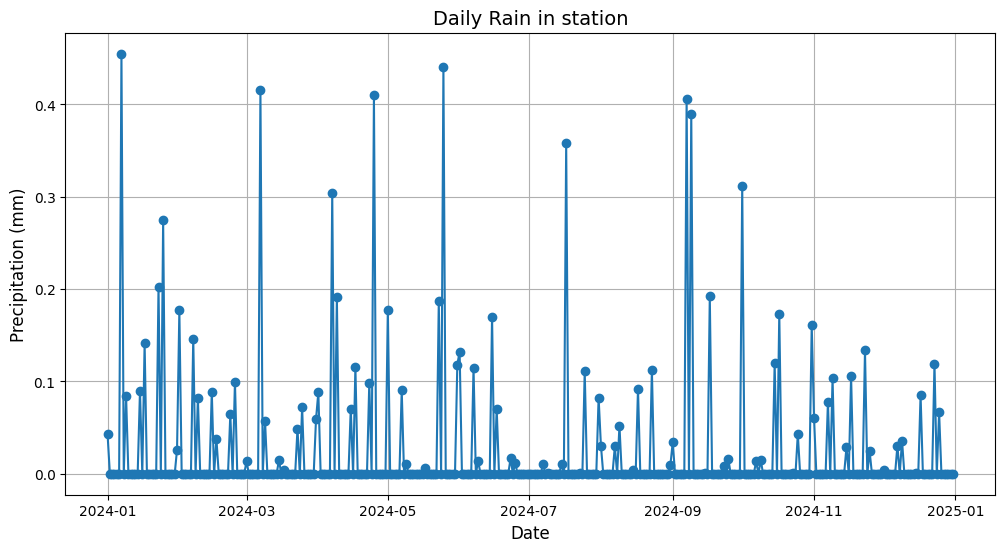

2025-09-29 21:40:39,944 - Lstm Era5 - INFO - TESTEEE


In [ ]:
timeseries = access_era_5.recuperar_dados_era_5()
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
dias = timeseries['valid_time']

total_chuva = timeseries['tp']
dias = pd.to_datetime(dias)

# Faz o plot
plt.figure(figsize=(12,6))
plt.plot(dias, total_chuva, marker="o", linestyle="-")

plt.title("Daily Rain in station", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True)
plt.show()


In [3]:
lookback = 7
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequences_pytorch(total_chuva, lookback=lookback)
train_size = int(len(timeseries) * 0.64)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = dias[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")


2025-09-29 21:40:39,951 - Lstm Era5 - INFO - Preparando sequências com um lookback de 7 dias.
2025-09-29 21:40:39,961 - Lstm Era5 - INFO - Sequências criadas. Treino: 234 amostras, Teste: 125 amostras.


In [4]:
n_epochs = 10
batch_size = 32
model = LstmModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

In [ ]:
logger.info(f"Iniciando treinamento do modelo por {n_epochs} épocas com batch_size de {batch_size}.")

# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    logger.debug(f"Época {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(loader):.6f}")

# --- Bloco de Avaliação Final (executado apenas uma vez) ---
logger.info("Treinamento finalizado.")
model.eval()  # modo avaliação
with torch.no_grad():
    # Previsões no conjunto de teste
    y_pred_test = model(X_test)
    
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.detach().cpu().numpy().flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten()
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    
    # MSE
    mse = mean_squared_error(y_test_np, y_pred_np)
    
    # MAE
    mae = mean_absolute_error(y_test_np, y_pred_np)
    
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")



# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
logger.info("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Pega as previsões finais do conjunto de teste
    y_pred_final = model(X_test)
    valores_previstos = y_pred_final.detach().cpu().numpy()
    valores_esperados = y_test.detach().cpu().numpy()

    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = valores_previstos[i][0]
        esperado = valores_esperados[i][0]
        logger.info(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")

2025-09-29 21:40:40,636 - Lstm Era5 - INFO - Iniciando treinamento do modelo por 10 épocas com batch_size de 32.
2025-09-29 21:40:40,832 - Lstm Era5 - DEBUG - Época 1/10, Loss: 0.005579
2025-09-29 21:40:40,995 - Lstm Era5 - DEBUG - Época 2/10, Loss: 0.004745
2025-09-29 21:40:41,162 - Lstm Era5 - DEBUG - Época 3/10, Loss: 0.004867
2025-09-29 21:40:41,330 - Lstm Era5 - DEBUG - Época 4/10, Loss: 0.004706
2025-09-29 21:40:41,496 - Lstm Era5 - DEBUG - Época 5/10, Loss: 0.004852
2025-09-29 21:40:41,660 - Lstm Era5 - DEBUG - Época 6/10, Loss: 0.004512
2025-09-29 21:40:41,829 - Lstm Era5 - DEBUG - Época 7/10, Loss: 0.004531
2025-09-29 21:40:41,992 - Lstm Era5 - DEBUG - Época 8/10, Loss: 0.004698
2025-09-29 21:40:42,158 - Lstm Era5 - DEBUG - Época 9/10, Loss: 0.006245
2025-09-29 21:40:42,325 - Lstm Era5 - DEBUG - Época 10/10, Loss: 0.004592
2025-09-29 21:40:42,326 - Lstm Era5 - INFO - Treinamento finalizado.
2025-09-29 21:40:42,343 - Lstm Era5 - INFO - Avaliação do Modelo - RMSE: 0.0662, MSE: 0


--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---


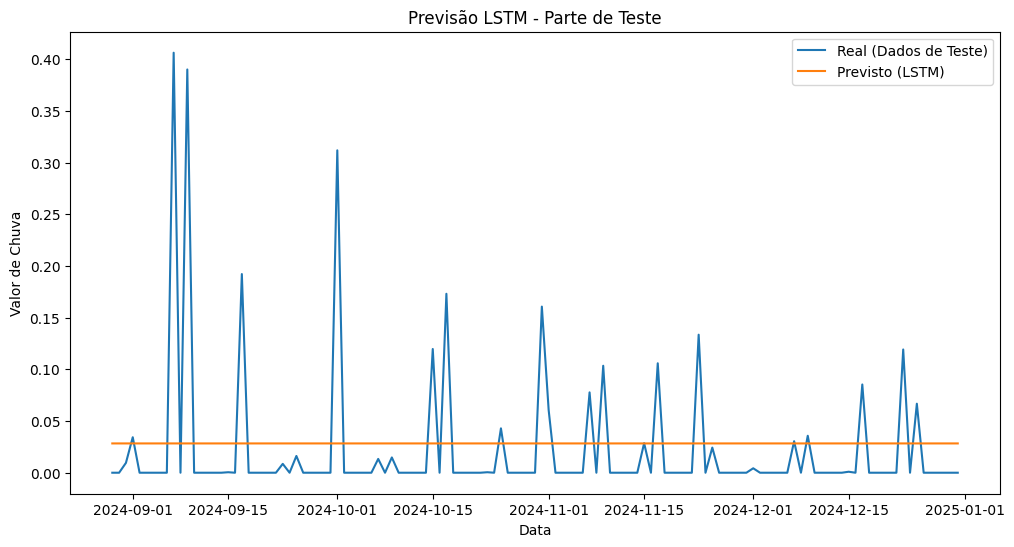

2025-09-29 21:40:42,494 - Lstm Era5 - INFO - Execução do script LSTM com ERA 5 finalizada.


In [6]:
plt.figure(figsize=(12, 6))
plt.plot(test_date, y_test_np, label="Real (Dados de Teste)")
plt.plot(test_date, y_pred_np, label="Previsto (LSTM)")
plt.title("Previsão LSTM - Parte de Teste")
plt.xlabel("Data")
plt.ylabel("Valor de Chuva")
plt.legend()
plt.show()
logger.info("Execução do script LSTM com ERA 5 finalizada.")